# Prototyping all of our functions in this notebook

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
datadir = "images"

In [3]:
# first time only
# load all images in the images directory
images = []
for filename in os.listdir(datadir):
    img = cv2.imread(os.path.join(datadir, filename))
    if img is not None:
        images.append(img)

# store as npz file
np.savez_compressed("images.npz", images)

C:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [4]:
# all other times
images = np.load("images.npz")["arr_0"]

ValueError: Object arrays cannot be loaded when allow_pickle=False

# Color transfer (E. Reinhard)
(Rule based: level 1)

# LAB color transfer


In [ ]:
def color_transfer_lab_mean(source_img_path, target_img_path):
    """
    Color transfer using Reinhard's method
    
    @param source_img_path: path to source image
    @param target_img_path: path to target image
    @return: color transferred image
    """
    source = cv2.imread(source_img_path)
    target = cv2.imread(target_img_path)
    
    # convert images from RGB to L*a*b* color space
    source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
    target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB).astype("float32")

    # split the images into their respective color channels
    (lSource, aSource, bSource) = cv2.split(source)
    (lTarget, aTarget, bTarget) = cv2.split(target)

    # compute the mean and standard deviation of each color channel
    (lMeanSrc, lStdSrc) = (lSource.mean(), lSource.std())
    (lMeanTar, lStdTar) = (lTarget.mean(), lTarget.std())
    (aMeanSrc, aStdSrc) = (aSource.mean(), aSource.std())
    (aMeanTar, aStdTar) = (aTarget.mean(), aTarget.std())
    (bMeanSrc, bStdSrc) = (bSource.mean(), bSource.std())
    (bMeanTar, bStdTar) = (bTarget.mean(), bTarget.std())

    # subtract the means from the target image
    lTarget -= lMeanTar
    aTarget -= aMeanTar
    bTarget -= bMeanTar

    # Scale the target channels 
    lTarget = (lStdSrc / lStdTar) * lTarget
    aTarget = (aStdSrc / aStdTar) * aTarget
    bTarget = (bStdSrc / bStdTar) * bTarget

    # add the source means
    lTarget += lMeanSrc
    aTarget += aMeanSrc
    bTarget += bMeanSrc

    # clip the pixel intensities to [0, 255]
    lTarget = np.clip(lTarget, 0, 255)
    aTarget = np.clip(aTarget, 0, 255)
    bTarget = np.clip(bTarget, 0, 255)

    # merge the channels together and convert back to RGB color space
    output = cv2.merge([lTarget, aTarget, bTarget])
    output = cv2.cvtColor(output.astype("uint8"), cv2.COLOR_LAB2BGR)

    return output

# Distribution Aware Image Color Transfer 
(Rule based: level 2)

In [2]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from matplotlib import color_sequences

In [3]:
def get_labels(src_img):
    bandwidth = estimate_bandwidth(src_img, quantile=0.1, n_samples=100)
    ms_clf = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms_labels = ms_clf.fit_predict(src_img)
    return ms_labels

In [4]:
def get_dominant_color_regions(ms_labels, source_img):
    # perform mean shift clustering on the image
    # to get the dominant color regions

    # get unique labels and their corresponding count
    unique_labels, label_counts = np.unique(ms_labels, return_counts=True)
    print(np.unique(unique_labels))
    print(label_counts)

    DCR = []

    # loop over the unique labels returned by the MeanShift
    print("starting first for loop")
    for label in unique_labels:
        # grab the image pixels that belong to the current label
        label_mask = (ms_labels == label)
        label_pixels = source_img[label_mask]
        print("shape = ", source_img[label_mask].shape)

        # get the dominant color
        if len(label_pixels) > 0:
            dominant_color = label_pixels[np.argmax(label_counts)]
        else:
            dominant_color = np.array([0, 0, 0])

        DCR.append(dominant_color)

    # form an image with the dominant color regions
    DCR_img = np.zeros(source_img.shape, dtype="uint8")
    for label, color in zip(unique_labels, DCR):
        label_mask = (ms_labels == label)
        DCR_img[ms_labels == label] = color * 255
    
    return DCR_img

(422, 750, 3)


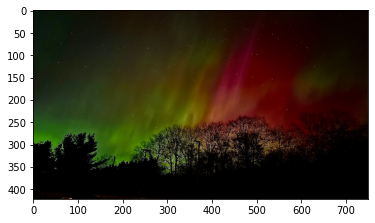

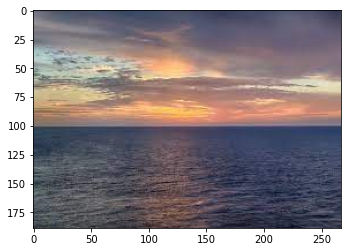

In [6]:
s = cv2.cvtColor(cv2.imread('images/nothern_lights.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
# make the image 1/4th its original size
s = cv2.resize(s, (0, 0), fx=0.25, fy=0.25)
print(s.shape)
plt.figure()
plt.imshow(s)
plt.show()

t = cv2.cvtColor(cv2.imread('images/ocean.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
# make the image 1/4th its original size
# t = cv2.resize(t, (0, 0), fx=0.25, fy=0.25)
plt.imshow(t)
plt.show()

In [7]:
# get the dominant color regions for the images
h, w, c = s.shape
labels = np.zeros((h * w, c), dtype=np.int32)
for i in range(c):
    l = get_labels(s.reshape((-1, 3)).astype(np.float32))
    labels[:, i] = l
labels = labels.reshape((h, w, c))

In [9]:
print(labels.shape)
print(s.shape)
DCR_image_s = get_dominant_color_regions(labels, s) 
print(np.unique(labels))

(422, 750, 3)
(422, 750, 3)
[0 1 2 3 4 5 6 7]
[574002 230994 129204  14118    525     57     33    567]
starting first for loop
shape =  (574002,)
shape =  (230994,)
shape =  (129204,)
shape =  (14118,)
shape =  (525,)
shape =  (57,)
shape =  (33,)
shape =  (567,)
[0 1 2 3 4 5 6 7]


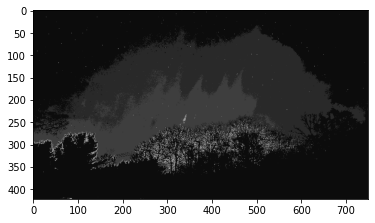

In [10]:
# plot the dominant color regions
plt.figure()
plt.imshow(cv2.cvtColor(DCR_image_s, cv2.COLOR_BGR2RGB))
# plt.imshow(DCR_image_s)
plt.show()

In [11]:
ht, wt, ct = t.shape
labels_t = np.zeros((ht * wt, ct), dtype=np.int32)
for i in range(ct):
    lt = get_labels(t.reshape((-1, 3)).astype(np.float32))
    labels_t[:, i] = lt
labels_t = labels_t.reshape((ht, wt, ct))

In [12]:
DCR_image_t = get_dominant_color_regions(labels_t, t) 

[0 1 2 3]
[78876 45408 19293  7812]
starting first for loop
shape =  (78876,)
shape =  (45408,)
shape =  (19293,)
shape =  (7812,)


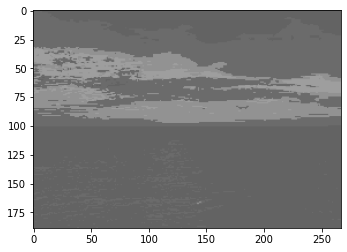

In [13]:
plt.figure()
plt.imshow(cv2.cvtColor(DCR_image_t, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from scipy.stats import entropy
from scipy.optimize import linear_sum_assignment
from scipy.sparse import csr_matrix, lil_matrix

In [24]:
# get Earth Mover's Distance between the two images
def get_emd(source_dcr, target_dcr):
    # Convert the DCR images to numpy arrays
    source_dcr_arr = np.array(source_dcr, dtype=np.uint8)
    target_dcr_arr = np.array(target_dcr, dtype=np.uint8)

    # Calculate the probability matrix
    source_dcr_flat = source_dcr_arr.reshape(-1, 3)
    target_dcr_flat = target_dcr_arr.reshape(-1, 3)
    distance_matrix = np.zeros((source_dcr_flat.shape[0], target_dcr_flat.shape[0]))
    for i in range(source_dcr_flat.shape[0]):
        for j in range(target_dcr_flat.shape[0]):
            distance_matrix[i][j] = calculate_distance(source_dcr_flat[i], target_dcr_flat[j])
    cost_matrix = distance_matrix / np.max(distance_matrix)
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # prob_matrix = np.zeros((source_dcr_flat.shape[0], target_dcr_flat.shape[0]))
    # for i, j in zip(row_indices, col_indices):
    #     prob_matrix[i, j] = 1

    # # Calculate the EMD
    # emd = entropy(np.sum(prob_matrix, axis=1)) + entropy(np.sum(prob_matrix, axis=0)) - 2 * entropy(prob_matrix.flatten())

    prob_matrix = lil_matrix((source_dcr_flat.shape[0], target_dcr_flat.shape[0]), dtype=np.float32)
    prob_matrix[row_indices, col_indices] = 1

    # Calculate the EMD
    emd = entropy(np.sum(prob_matrix, axis=1)) + entropy(np.sum(prob_matrix, axis=0)) - 2 * entropy(prob_matrix.toarray().flatten())
    return emd


In [29]:
def calculate_distance(dcr1, dcr2):
    # Parameters
    delta_s = 0.6
    delta_c = 1.0

    # Calculate the distance between two DCRs
    spatial_distance = np.linalg.norm(dcr1[:2] - dcr2[:2])
    color_distance = np.linalg.norm(dcr1[2:] - dcr2[2:])
    distance = np.exp(-spatial_distance**2 / (2 * delta_s**2)) * np.exp(-color_distance**2 / (2 * delta_c**2))

    return distance

In [41]:
# save dcr images as npy files
np.save("dcr_image_s.npy", DCR_image_s)
np.save("dcr_image_t.npy", DCR_image_t)

In [3]:
#load dcr images
DCR_image_s = np.load("dcr_image_s.npy")
DCR_image_t = np.load("dcr_image_t.npy")

In [4]:
# Convert the DCR images to numpy arrays
source_dcr_arr = np.array(DCR_image_s, dtype=np.uint8)
target_dcr_arr = np.array(DCR_image_t, dtype=np.uint8)

# Calculate the probability matrix
source_dcr_flat = source_dcr_arr.reshape(-1, 3)
target_dcr_flat = target_dcr_arr.reshape(-1, 3)

In [6]:
delta_s_sq = 0.36
delta_c_sq = 1.0
from scipy.spatial.distance import cdist

In [6]:
distance_matrix = np.exp(-cdist(source_dcr_flat[:,:2], target_dcr_flat[:,:2])**2 / (2 * delta_s_sq)) \
                  * np.exp(-cdist(source_dcr_flat[:,2:], target_dcr_flat[:,2:])**2 / (2 * delta_c_sq))

: 

: 

In [26]:
emd = get_emd(DCR_image_s, DCR_image_t)
print("EMD:", emd)

KeyboardInterrupt: 

## new trial

(169, 300, 3)


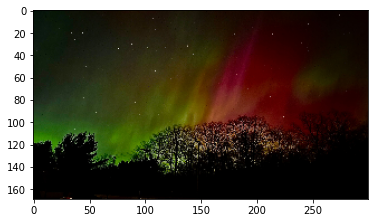

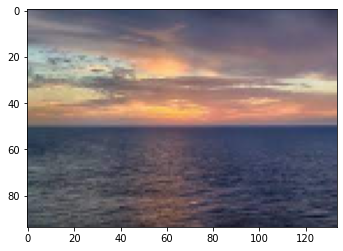

In [7]:
s = cv2.cvtColor(cv2.imread('images/nothern_lights.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
s = cv2.resize(s, (0, 0), fx=0.10, fy=0.10)
print(s.shape)
plt.figure()
plt.imshow(s)
plt.show()

t = cv2.cvtColor(cv2.imread('images/ocean.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
t = cv2.resize(t, (0, 0), fx=0.5, fy=0.5)
plt.imshow(t)
plt.show()

In [8]:
# get the dominant color regions for the images
h, w, c = s.shape
labels = np.zeros((h * w, c), dtype=np.int32)
for i in range(c):
    l = get_labels(s.reshape((-1, 3)).astype(np.float32))
    labels[:, i] = l
labels = labels.reshape((h, w, c))

In [9]:
print(labels.shape)
print(s.shape)
DCR_image_s = get_dominant_color_regions(labels, s) 
print(np.unique(labels))

(169, 300, 3)
(169, 300, 3)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[88419 33303  7029 19518   891   426   339   360   219    24    15  1488
     3    60     6]
starting first for loop
shape =  (88419,)
shape =  (33303,)
shape =  (7029,)
shape =  (19518,)
shape =  (891,)
shape =  (426,)
shape =  (339,)
shape =  (360,)
shape =  (219,)
shape =  (24,)
shape =  (15,)
shape =  (1488,)
shape =  (3,)
shape =  (60,)
shape =  (6,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


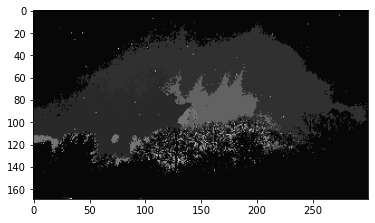

In [10]:
# plot the dominant color regions
plt.figure()
plt.imshow(cv2.cvtColor(DCR_image_s, cv2.COLOR_BGR2RGB))
# plt.imshow(DCR_image_s)
plt.show()

In [11]:
ht, wt, ct = t.shape
labels_t = np.zeros((ht * wt, ct), dtype=np.int32)
for i in range(ct):
    lt = get_labels(t.reshape((-1, 3)).astype(np.float32))
    labels_t[:, i] = lt
labels_t = labels_t.reshape((ht, wt, ct))

[0 1 2 3]
[21171 10386  4380  1851]
starting first for loop
shape =  (21171,)
shape =  (10386,)
shape =  (4380,)
shape =  (1851,)


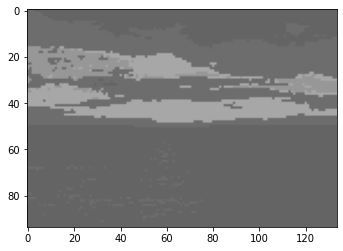

In [12]:
DCR_image_t = get_dominant_color_regions(labels_t, t) 
plt.figure()
plt.imshow(cv2.cvtColor(DCR_image_t, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
# Convert the DCR images to numpy arrays
source_dcr_arr = np.array(DCR_image_s, dtype=np.uint8)
target_dcr_arr = np.array(DCR_image_t, dtype=np.uint8)

# Calculate the probability matrix
source_dcr_flat = source_dcr_arr.reshape(-1, 3)
target_dcr_flat = target_dcr_arr.reshape(-1, 3)

In [14]:
delta_s_sq = 0.36
delta_c_sq = 1.0

In [15]:
distance_matrix = np.exp(-cdist(source_dcr_flat[:,:2], target_dcr_flat[:,:2])**2 / (2 * delta_s_sq)) \
                  * np.exp(-cdist(source_dcr_flat[:,2:], target_dcr_flat[:,2:])**2 / (2 * delta_c_sq))

In [16]:
cost_matrix = distance_matrix / np.max(distance_matrix)
row_indices, col_indices = linear_sum_assignment(cost_matrix)

In [17]:
prob_matrix = lil_matrix((source_dcr_flat.shape[0], target_dcr_flat.shape[0]), dtype=np.float32)
prob_matrix[row_indices, col_indices] = 1

In [18]:
emd = entropy(np.sum(prob_matrix, axis=1)) + entropy(np.sum(prob_matrix, axis=0)) - 2 * entropy(prob_matrix.toarray().flatten())

In [19]:
print("EMD:", emd)

EMD: [-9.442329 -9.442329 -9.442329 ... -9.442329 -9.442329 -9.442329]
